Create masks using annotations from stanford campus dataset + manual background stuff annotations (roads, sidewalk, greens and other)

In [1]:
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
import subprocess
import pandas as pd
import numpy as np
from pycocotools.coco import COCO
from matplotlib.path import Path as PathPlt

In [2]:
class VideoDataset:
    def __init__(self, data_root="/media/hdd/stanford_campus_dataset"):
        self.data_root = data_root
        # 1. Get available scenes
        scenes_path = Path(data_root + "/videos").glob('./*')
        self.scenes = {scene.name: {"path": scene, "videos": {}} for scene in scenes_path}
        
        # 2. For each scene, get list of available videos
        for scene_name, scene in self.scenes.items():
            videos = scene["path"].glob("./*")
            for video_path in videos:
                scene["videos"][video_path.name] = video_path / "video.mov"
        
    def get_scenes(self):
        return [k for k, v in self.scenes.items()]
        
    def get_frame(self, scene_name, video_name, is_last=False):
        cap = cv2.VideoCapture(str(self.scenes[scene_name]["videos"][video_name]))
        if is_last:
            cap.set(cv2.CAP_PROP_POS_FRAMES, cap.get(cv2.CAP_PROP_FRAME_COUNT)-1)
        success, frame = cap.read()
        if not success:
            print(f"Can't read first frame for scene '{scene_name}' and video '{video_name}'")
        cap.release()
        return frame
    
    def split_video(self, scene_name, video_name, destination_root='/media/hdd/stanford_campus_dataset/frames'):
        d_root = Path(destination_root)
        destination_path = d_root / scene_name / video_name
        destination_path.mkdir(parents=True, exist_ok=True)
        
        # ffmpeg -i video.webm thumb%04d.jpg -hide_banner
        
        command = ['ffmpeg',
                       '-i', str(self.scenes[scene_name]["videos"][video_name]),
                       str(destination_path / "frame_%6d.jpg")]
        p = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=False, bufsize=0)
        out, err = p.communicate()
        print(f"Error: {err}")
        return p
    
    def load_annotations(self, scene_name, video_name):
        ann_path = Path(self.data_root) / "annotations" / scene_name / video_name / "annotations.txt"
        if not ann_path.is_file:
            raise Exception(f"Path {ann_path} does not exist")
        df = pd.read_csv(ann_path, names=['track_id', 'xmin', 'ymin', 'xmax', 'ymax', 
                                         'frame', 'lost', 'occluded', 'generated', 'label'], 
                         header=None, sep=' ')
        print(df.head())
        return df
    
    def load_annotation_stuff(self, scene_name, video_name):
        ann_path = Path(self.data_root) / "annotations" / scene_name / video_name / scene_name + "_00.json"
        coco=COCO(ann_path)
        catIDs = coco.getCatIds()
        cats = coco.loadCats(catIDs)

In [17]:
# 1. load videos
v_dataset = VideoDataset()
print(v_dataset.get_scenes())

# scene_name = "bookstore"
# video = "video0"
scene_name = "deathCircle"
video = "video1"

first_frame = v_dataset.get_frame(scene_name, video)

['nexus', 'coupa', 'little', 'gates', 'bookstore', 'quad', 'hyang', 'deathCircle']


In [18]:
# 2. Split video into frames
v_dataset.split_video(scene_name, video)

Error: b"ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers\n  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609\n  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

In [19]:
# 3. Load annotations for bboxes
ann_df = v_dataset.load_annotations(scene_name, video)

   track_id  xmin  ymin  xmax  ymax  frame  lost  occluded  generated  label
0         0   616  1828   641  1888  11000     1         0          0  Biker
1         0   616  1828   641  1888  11001     1         0          1  Biker
2         0   616  1828   641  1888  11002     1         0          1  Biker
3         0   616  1828   641  1888  11003     1         0          1  Biker
4         0   616  1828   641  1888  11004     1         0          1  Biker


In [20]:
classes = ann_df["label"].unique()
print(f"Classes: {classes}")
min_frame = ann_df["frame"].min()
max_frame = ann_df["frame"].max()
print(f"min frame: {min_frame}")
print(f"max frame: {max_frame}")

Classes: ['Biker' 'Pedestrian' 'Cart' 'Skater' 'Bus' 'Car']
min frame: 0
max frame: 14064


In [21]:
root_dir = "/media/hdd/stanford_campus_dataset"
ann_path = Path(root_dir) / "annotations" / scene_name / video / ("stuff.json")
coco=COCO(ann_path)
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
print(cats)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[{'id': 1, 'name': 'road', 'supercategory': '', 'color': '#e81bac', 'metadata': {}, 'keypoint_colors': []}, {'id': 2, 'name': 'sidewalk', 'supercategory': '', 'color': '#70e791', 'metadata': {}, 'keypoint_colors': []}, {'id': 3, 'name': 'greens', 'supercategory': '', 'color': '#d57fe4', 'metadata': {}, 'keypoint_colors': []}, {'id': 4, 'name': 'other', 'supercategory': '', 'color': '#8a04d4', 'metadata': {}, 'keypoint_colors': []}]


[2]


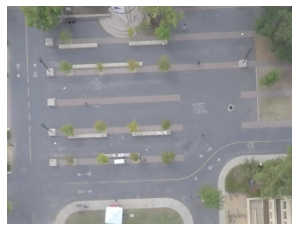

[52, 53, 54, 55, 57, 58, 60, 62, 63, 64, 65, 66, 67]


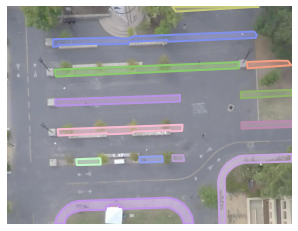

In [8]:
import skimage.io as io

filterClasses = ['sidewalk']
catIds = coco.getCatIds(catNms=filterClasses) 
print(catIds)
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
img = coco.loadImgs(imgIds[0])[0]
I = io.imread('{}/annotations/{}/{}/{}'.format(root_dir,scene_name,video, "reference.jpg"))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
print(annIds)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [ ]:
anns

In [9]:
def get_polygons(coco, filter_classes):
    catIds = coco.getCatIds(catNms=filter_classes) 

    # Get all images containing the above Category IDs
    imgIds = coco.getImgIds(catIds=catIds)
    img = coco.loadImgs(imgIds[0])[0]
#     I = io.imread('{}/annotations/{}/{}/{}'.format(root_dir,scene_name,video, img['file_name']))/255.0
#     plt.axis('off')
#     plt.imshow(I)
#     plt.show()

    # Load and display instance annotations
#     plt.imshow(I)
#     plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    print(f"{len(anns)} annoations for filter_classes '{filter_classes}' loaded")
    return anns

In [15]:
def create_mask_from_polygons(annotations, mask_base, show=False):
    masks = []
    h, w = mask_base.shape
    mask_res = mask_base.copy()
    for ann in annotations:
#         print(ann["id"])
        if 'segmentation' in ann:
            seg = ann['segmentation'][0]
            points = np.array(seg).reshape((int(len(seg)/2), 2))
            points = np.flip(points, axis=1)
            poly_path=PathPlt(points)

            x, y = np.mgrid[:h, :w]
            coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (width*height,2)

            mask = poly_path.contains_points(coors).reshape(mask_shape)
            masks.append(mask)
            mask_res = np.logical_or(mask_res, mask)
#             if show:
#                 plt.imshow(mask.reshape(mask_shape))
#                 plt.show()
    if show:
        plt.imshow(mask_res)
        plt.show()
    return mask_res, masks

In [11]:
# set classes dict
classes_dict = {0: "other_stuff", 1: "road", 2: "sidewalk", 3: "greens", 4: "Biker", 
                5: "Pedestrian", 6: "Skater", 7: "Cart", 8: "Car", 9: "Bus"}



# for each frame, create mask
mask_base = np.zeros(first_frame.shape[0: 2])
mask_other_stuff = np.zeros(first_frame.shape[0: 2])
print(mask_base.shape)
mask_shape = mask_base.shape

(1088, 1424)


2 annoations for filter_classes '['road']' loaded
13 annoations for filter_classes '['sidewalk']' loaded


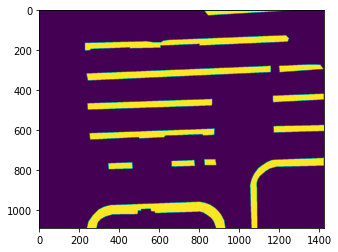

22 annoations for filter_classes '['greens']' loaded


In [16]:
anns_road = get_polygons(coco, ['road'])
mask_road, masks_road = create_mask_from_polygons(anns_road, mask_base, show=False)

anns_sidewalk = get_polygons(coco, ['sidewalk'])
mask_sidewalk, masks_sidewalk = create_mask_from_polygons(anns_sidewalk, mask_base, show=True)

anns_greens = get_polygons(coco, ['greens'])
mask_greens, masks_greens = create_mask_from_polygons(anns_greens, mask_base, show=False)

In [ ]:
ann_df.head()

In [ ]:
def create_mask_from_bbox(df, idx_frame, mask_shape, label=None, show=False):
    mask_out = np.zeros(mask_shape)
    masks = []
    if label is None:
        data = ann_df[ann_df["frame"] == idx_frame].copy()
    else:
        data = ann_df[(ann_df["frame"] == idx_frame) & (ann_df["label"] == label)].copy()
    for index, row in data.iterrows():
        h, w = mask_shape

        ymin = row.ymin
        xmin = row.xmin
        ymax = row.ymax
        xmax = row.xmax
        points = np.array([ymin, xmin, ymax, xmin, ymax, xmax, ymin, xmax]).reshape((4, 2))

        poly_path=PathPlt(points)

        x, y = np.mgrid[:h, :w]
        coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (width*height,2)

        mask_new = poly_path.contains_points(coors).reshape(mask_base.shape)
        mask_out = np.logical_or(mask_out, mask_new)
        masks.append(mask_new)
    if show:
        plt.imshow(mask_out)
        plt.show()
        
    return mask_out, masks
        
#         plt.imshow(mask_new)
#         plt.show()
#         break

In [ ]:
idx_frame = 10000
mask_out, _ = create_mask_from_bbox(ann_df, idx_frame, mask_base.shape, label="Biker", show=True)

In [ ]:
# create dict of categories
category_dict = {0: "other_stuff", 1: "road", 2: "sidewalk", 3: "greens", 4: "Biker",
                5: "Pedestrian", 6: "Skater", 7: "Cart", 8: "Car", 9: "Bus"}

category_clr = {0: [0, 0, 0], 1: [128, 64, 128], 2: [130, 76, 0], 3: [107, 142, 35], 4: [28, 42, 168],
                5: [255, 22, 96], 6: [102, 51, 0], 7: [9, 143, 150], 8: [119, 11, 32], 9: [112, 150, 146]}

def get_label_id(cat_dict, label_name):
    for k, v in cat_dict.items():
        if v == label_name:
            return k
    return -1

def get_clr(cat_clr, label_id):
    for k, v in cat_clr.items():
        if k == label_id:
            return v
    return None

In [ ]:

# create color mask
mask_dict = {}
mask_dict[0] = mask_base.copy()
mask_dict[1] = mask_road.copy()
mask_dict[2] = mask_sidewalk.copy()
mask_dict[3] = mask_greens.copy()
mask_biker, _ = create_mask_from_bbox(ann_df, idx_frame, mask_base.shape, label="Biker")
mask_dict[4] = mask_biker.copy()
mask_pedestrian, _ = create_mask_from_bbox(ann_df, idx_frame, mask_base.shape, label="Pedestrian")
mask_dict[5] = mask_pedestrian.copy()
mask_skater, _ = create_mask_from_bbox(ann_df, idx_frame, mask_base.shape, label="Skater")
mask_dict[6] = mask_skater.copy()
mask_cart, _ = create_mask_from_bbox(ann_df, idx_frame, mask_base.shape, label="Cart")
mask_dict[7] = mask_cart.copy()
mask_car, _ = create_mask_from_bbox(ann_df, idx_frame, mask_base.shape, label="Car")
mask_dict[8] = mask_car.copy()
mask_bus, _ = create_mask_from_bbox(ann_df, idx_frame, mask_base.shape, label="Bus")
mask_dict[9] = mask_bus.copy()

In [ ]:
mask_out = mask_base.copy()
mask_out = np.dstack([mask_out]*3)
print(mask_out.shape)
for cat_id in range(1, max(list(category_dict.keys()))+1):
    mask_cur = mask_dict[cat_id]
    mask_bool = mask_cur.astype(bool)
    clr = get_clr(category_clr, cat_id)
    mask_out[mask_bool, 0] = clr[0]
    mask_out[mask_bool, 1] = clr[1]
    mask_out[mask_bool, 2] = clr[2]

plt.imshow(mask_out.astype('uint8'))
plt.show()

In [ ]:
a = np.zeros((3, 3))
a[1:2, 1:3] = 1
b = np.zeros((3, 3))
b[1:3, 1:2] = 2
print(a)
print(b)
idx = np.logical_or(a, b)
print(idx)

In [ ]:
a.astype(bool)

In [ ]:
np.logical_or(a, b).astype(int) - np.ones((3, 3))

In [ ]:
a[np.logical_or(a, b)] = 3
print(a)